In [1]:
import pandas as pd 
#import geopandas as gp
#import altair as alt 
#import gpdvega 
import json
import matplotlib.pyplot as plt
#alt.renderers.enable('notebook') # render for Jupyter Notebook

DATA_DIR = '/content/jupyter/mta-accessibility/'

In [2]:
elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
elevators = elevators[ (elevators.equipment_type == 'EL') ] # & (elevators.ada_compliant == 'Y')
elevators.head(25)

,Unnamed: 0,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street,st_name_opd_format,line,notes,geometry,lat,lon
0,0,125 St,EL125,125 St & Lexington Ave (NE corner) to Mezzanin...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,4/5/6/METRO-NORTH,Y,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594
1,1,125 St,EL142,125 St & St Nicholas Ave (SW corner) to Mezzan...,MN,A/B/C/D,EL,Y,Y,both directions,A/B/C/D,Y,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248
2,2,125 St,EL143,Mezzanine to downtown Platform,MN,A/B/C/D,EL,Y,Y,downtown,A/B/C/D,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248
3,3,125 St,EL126,Mezzanine to Platforms for service in both dir...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,4/5/6/METRO-NORTH,N,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594
4,4,125 St,EL144,Mezzanine to uptown Platform,MN,A/B/C/D,EL,Y,Y,uptown,A/B/C/D,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248
8,8,135 St,EL180,Lenox Ave & 181 St (NE corner) to uptown Platform,MN,2/3,EL,Y,Y,uptown,2/3,N,135th St,2-3,"2,3-all times",POINT (-73.94077000106708 40.8142290003391),40.814229,-73.940770
9,9,135 St,EL181,Lenox Ave & 181 St (SW corner) to downtown Pla...,MN,2/3,EL,Y,Y,downtown,2/3,N,135th St,2-3,"2,3-all times",POINT (-73.94077000106708 40.8142290003391),40.814229,-73.940770
10,10,14 St - 8 Av,EL221,8th Ave & 14 St (SW corner) to Mezzanine for s...,MN,A/C/E/L,EL,Y,Y,both directions,A/C/E/L,N,14th St,A-C-E,"A,E-all times, C-all times exc nights",POINT (-74.00168999937027 40.7408930001933),40.740893,-74.001690
11,11,14 St - 8 Av,EL222,Mezzanine to downtown A/C/E Platform,MN,A/C/E/L,EL,Y,Y,downtown,A/C/E/L,N,14th St,A-C-E,"A,E-all times, C-all times exc nights",POINT (-74.00168999937027 40.7408930001933),40.740893,-74.001690
12,12,14 St - 8 Av,EL223,Mezzanine to uptown A/C/E Platform,MN,A/C/E/L,EL,Y,Y,uptown,A/C/E/L,N,14th St,A-C-E,"A,E-all times, C-all times exc nights",POINT (-74.00168999937027 40.7408930001933),40.740893,-74.001690


In [3]:
# correct some of the data
elevators.loc[elevators.station_name == 'Howard Beach']['description'].replace(r'^(Mezzanine) and (Platform .*)$', r'\1 to \2', inplace=True)
elevators.loc[elevators.station_name == 'Howard Beach']['description'].replace(r'^(.*) Far Rockaway bound (.*)$', r'\1 southbound \2', inplace=True)
elevators[elevators.station_name == 'Howard Beach']

/opt/conda/envs/py3/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Unnamed: 0,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street,st_name_opd_format,line,notes,geometry,lat,lon
404,404,Howard Beach,EL491X,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301
405,405,Howard Beach,EL490X,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301
406,406,Howard Beach,EL495X,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301
407,407,Howard Beach,EL494X,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301
408,408,Howard Beach,EL493X,Mezzanine and Platform for southbound service,QNS,A,EL,Y,Y,NaN,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301
413,413,Howard Beach,EL492X,Mezzanine to Far Rockaway bound Platform,QNS,A,EL,Y,Y,NaN,A,N,Howard Beach - JFK Airport,A,A-all times,POINT (-73.83030100071032 40.66047600004959),40.660476,-73.830301


In [4]:
mapped_elevators = pd.read_csv(DATA_DIR+'data/processed/elevator_to_line_dir_station.csv')
mapped_elevators.head()

,Unnamed: 0,equipment_id,line,direction,station
0,230,EL103,1,south,191 St
1,21,EL103,1,north,191 St
2,185,EL122,6,manhattan,Pelham Bay Park
3,18,EL124,A,north,175 St
4,628,EL126,5,south,125 St


In [5]:
# the MTA direction information is incomplete!
platform_ids = mapped_elevators[['equipment_id', 'line', 'direction']].set_index('equipment_id')
platform_ids = platform_ids.apply(lambda t : '-'.join(t), axis=1).groupby(level=0).unique()
platform_ids = platform_ids.apply(lambda t : '/'.join(t))
elevators.set_index('equipment_id', inplace=True)
elevators['platform_id'] = platform_ids
elevators.reset_index(inplace=True)
elevators.head()

,equipment_id,Unnamed: 0,station_name,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street,st_name_opd_format,line,notes,geometry,lat,lon,platform_id
0,EL125,0,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,4/5/6/METRO-NORTH,Y,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,NaN
1,EL142,1,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,MN,A/B/C/D,EL,Y,Y,both directions,A/B/C/D,Y,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,NaN
2,EL143,2,125 St,Mezzanine to downtown Platform,MN,A/B/C/D,EL,Y,Y,downtown,A/B/C/D,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,A-south/D-south/B-south/C-south
3,EL126,3,125 St,Mezzanine to Platforms for service in both dir...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,4/5/6/METRO-NORTH,N,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,5-south/4-north/5-north/METRO-NORTH-south/METR...
4,EL144,4,125 St,Mezzanine to uptown Platform,MN,A/B/C/D,EL,Y,Y,uptown,A/B/C/D,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,C-north/B-north/A-north/D-north


In [6]:
mezz_re = '.*([Mm]ezzanine|[Bb]alcony).*'
mezz = elevators[elevators.description.str.match(mezz_re)].station_name.unique()
no_mezz = elevators[~elevators.description.str.match(mezz_re)].station_name.unique()
len(mezz), len(no_mezz), len(set(mezz).intersection(set(no_mezz)))

(76, 37, 10)

In [7]:
import re

def elevator_route(desc):
    def simplify(name):
        if re.match(r'.*[Pp]latform.*', name):
            return 'Platform'
        if re.match(r'.*(St|Av|Plaza|Blvd|Park|Sidewalk|Pl|Rd|Square).*', name):
            return 'Street'
        if re.match(r'.*Upper Mezzanine.*', name):
            return 'Upper Mezzanine'
        if re.match(r'.*Lower Mezzanine.*', name):
            return 'Lower Mezzanine'
        if re.match(r'.*(Mezzanine|[Bb]alcony).*', name):
            return 'Mezzanine'
        if name in ['PA Bus Terminal', 'Oculus Main Level']:
            return 'Street'
        return 'Unknown'

    # try "to" and "for" first
    m = re.search(r'^(.*?) (to|for) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))
    # then try for "and"
    m = re.search(r'^(.*?) (and) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))

    if re.match('^Mezzanine .*bound Platform$', desc):
        return ('Mezzanine', 'Platform')
    
    return ('Unknown', 'Unknown')

assert elevator_route('125 St & Lexington Ave to Mezzanine for service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Mezzanine to Platform for downtown A/C service') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to Platforms for service in both directions') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to uptown Platform') == ('Mezzanine', 'Platform')
assert elevator_route('161 St & River Ave (NE Corner) to Mezzanine to reach service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Street to # 6 Northbound platform') == ('Street', 'Platform')
assert elevator_route('Sidewalk entrance (east of the pedestrian skybridge) to Manhattan bound Platform') == ('Street', 'Platform')
assert elevator_route('G and 7 Mezzanines to Flushing-bound 7 Platform') == ('Mezzanine', 'Platform')

elevators['from'] = elevators.description.apply(lambda d : elevator_route(d)[0])
elevators['to'] = elevators.description.apply(lambda d : elevator_route(d)[1])
# some elevators record the street part explicitly
elevators.loc[elevators['connection_to_street'] == 'Y', 'from'] = 'Street'
elevators.head()



,equipment_id,Unnamed: 0,station_name,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,...,connection_to_street,st_name_opd_format,line,notes,geometry,lat,lon,platform_id,from,to
0,EL125,0,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,...,Y,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,NaN,Street,Mezzanine
1,EL142,1,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,MN,A/B/C/D,EL,Y,Y,both directions,...,Y,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,NaN,Street,Mezzanine
2,EL143,2,125 St,Mezzanine to downtown Platform,MN,A/B/C/D,EL,Y,Y,downtown,...,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,A-south/D-south/B-south/C-south,Mezzanine,Platform
3,EL126,3,125 St,Mezzanine to Platforms for service in both dir...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,...,N,125th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,5-south/4-north/5-north/METRO-NORTH-south/METR...,Mezzanine,Platform
4,EL144,4,125 St,Mezzanine to uptown Platform,MN,A/B/C/D,EL,Y,Y,uptown,...,N,125th St,A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ...",POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,C-north/B-north/A-north/D-north,Mezzanine,Platform


In [8]:
def make_canon(t):
    label, station, platform_id = t
    if label == 'Unknown':
        return 'Unknown-' + station
    if label == 'Platform':
        return '-'.join([str(x) for x in [label, station, platform_id]])
    return '-'.join([str(x) for x in [label, station]])

elevators['fqn_from'] = elevators[['from', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['fqn_to'] = elevators[['to', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['label_from'] = elevators[['from', 'station_name']].apply(lambda t : t[1] if t[0] == 'Street' else t[0], axis=1)
elevators['label_to'] = elevators['to']
elevators.head()

,equipment_id,Unnamed: 0,station_name,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,...,geometry,lat,lon,platform_id,from,to,fqn_from,fqn_to,label_from,label_to
0,EL125,0,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,...,POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,NaN,Street,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
1,EL142,1,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,MN,A/B/C/D,EL,Y,Y,both directions,...,POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,NaN,Street,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
2,EL143,2,125 St,Mezzanine to downtown Platform,MN,A/B/C/D,EL,Y,Y,downtown,...,POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,A-south/D-south/B-south/C-south,Mezzanine,Platform,Mezzanine-125 St,Platform-125 St-A-south/D-south/B-south/C-south,Mezzanine,Platform
3,EL126,3,125 St,Mezzanine to Platforms for service in both dir...,MN,4/5/6/METRO-NORTH,EL,Y,Y,both directions,...,POINT (-73.93759400055725 40.80413800058724),40.804138,-73.937594,5-south/4-north/5-north/METRO-NORTH-south/METR...,Mezzanine,Platform,Mezzanine-125 St,Platform-125 St-5-south/4-north/5-north/METRO-...,Mezzanine,Platform
4,EL144,4,125 St,Mezzanine to uptown Platform,MN,A/B/C/D,EL,Y,Y,uptown,...,POINT (-73.95224799734774 40.81107167299457),40.811072,-73.952248,C-north/B-north/A-north/D-north,Mezzanine,Platform,Mezzanine-125 St,Platform-125 St-C-north/B-north/A-north/D-north,Mezzanine,Platform


In [9]:
trains = mapped_elevators.set_index('equipment_id')
trains['platform_id'] = platform_ids
trains.reset_index(inplace=True)
trains['fqn_from'] = trains[['station', 'platform_id']].apply(lambda t : '-'.join(['Platform'] + [str(x) for x in t]), axis=1)
trains['fqn_to'] = trains[['station', 'line', 'direction', 'platform_id']].apply(lambda t : '-'.join(['Train'] + [str(x) for x in t]), axis=1)
trains['from'] = 'Platform'
trains['to'] = 'Train'
trains['label_from'] = 'Platform'
trains['label_to'] = trains[['line', 'direction']].apply(lambda t: '-'.join(t), axis=1)
trains['station_name'] = trains['station']
trains


,equipment_id,Unnamed: 0,line,direction,station,platform_id,fqn_from,fqn_to,from,to,label_from,label_to,station_name
0,EL103,230,1,south,191 St,1-south/1-north,Platform-191 St-1-south/1-north,Train-191 St-1-south-1-south/1-north,Platform,Train,Platform,1-south,191 St
1,EL103,21,1,north,191 St,1-south/1-north,Platform-191 St-1-south/1-north,Train-191 St-1-north-1-south/1-north,Platform,Train,Platform,1-north,191 St
2,EL122,185,6,manhattan,Pelham Bay Park,6-manhattan,Platform-Pelham Bay Park-6-manhattan,Train-Pelham Bay Park-6-manhattan-6-manhattan,Platform,Train,Platform,6-manhattan,Pelham Bay Park
3,EL124,18,A,north,175 St,A-north,Platform-175 St-A-north,Train-175 St-A-north-A-north,Platform,Train,Platform,A-north,175 St
4,EL126,628,5,south,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-5-south-5-south/4-north/5-north/M...,Platform,Train,Platform,5-south,125 St
5,EL126,1,4,north,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-4-north-5-south/4-north/5-north/M...,Platform,Train,Platform,4-north,125 St
6,EL126,419,5,north,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-5-north-5-south/4-north/5-north/M...,Platform,Train,Platform,5-north,125 St
7,EL126,1464,METRO-NORTH,south,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-METRO-NORTH-south-5-south/4-north...,Platform,Train,Platform,METRO-NORTH-south,125 St
8,EL126,1255,METRO-NORTH,north,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-METRO-NORTH-north-5-south/4-north...,Platform,Train,Platform,METRO-NORTH-north,125 St
9,EL126,1046,6,south,125 St,5-south/4-north/5-north/METRO-NORTH-south/METR...,Platform-125 St-5-south/4-north/5-north/METRO-...,Train-125 St-6-south-5-south/4-north/5-north/M...,Platform,Train,Platform,6-south,125 St


In [10]:
import networkx as nx

def add_to_graph(g, stations):
    if stations is None:
        el_subset, tr_subset = elevators, trains
    else:
        el_subset = elevators[elevators.station_name.isin(stations)]
        tr_subset = trains[trains.station.isin(stations)]

    for _, row in el_subset.iterrows():
        g.add_node(row['equipment_id'], node_type='Elevator', label=row['equipment_id'])
        g.add_node(row['fqn_from'], node_type=row['from'], label=row['label_from'])
        g.add_node(row['fqn_to'], node_type=row['to'], label=row['label_to'])
        g.add_edge(row['fqn_from'], row['equipment_id'])
        g.add_edge(row['equipment_id'], row['fqn_to'])

    for _, row in tr_subset.iterrows():
        g.add_node(row['fqn_to'], node_type=row['to'], label=row['label_to'])
        g.add_edge(row['fqn_from'], row['fqn_to'])

    return g


/opt/conda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


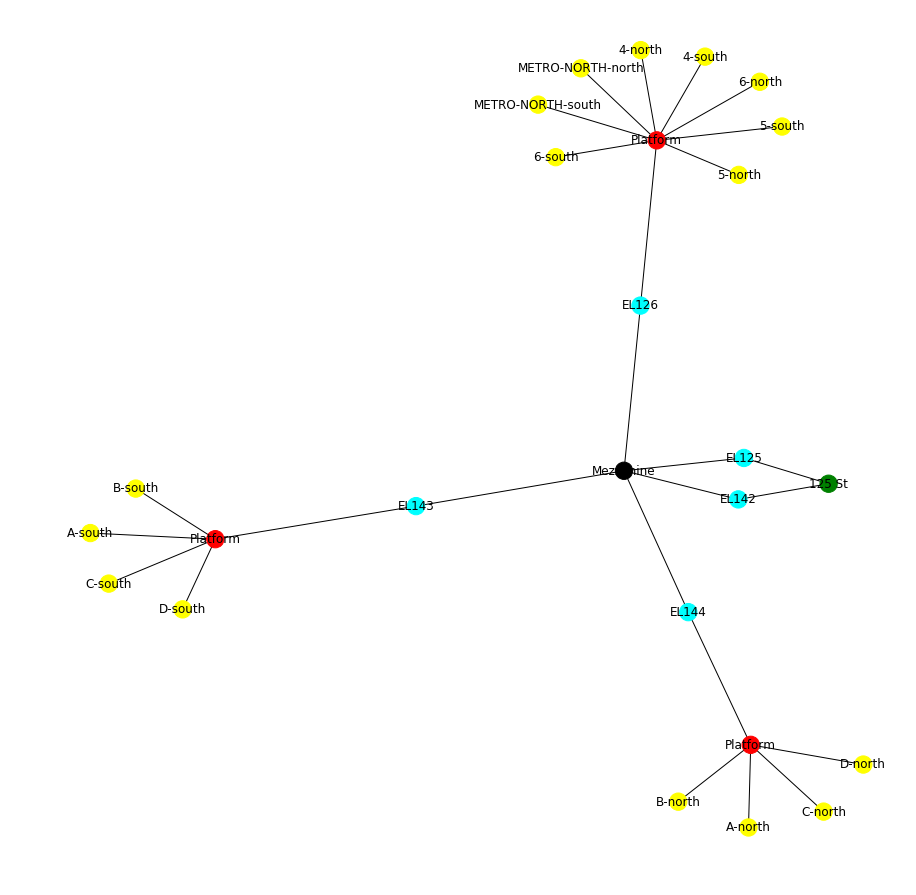

In [11]:
import matplotlib.pyplot as plt

stations = [
#    '14 St - Union Sq',
#    '149 St - 3 Av',
#    'Simpson St',
#    '42 St - Port Authority Bus Terminal',
      '125 St',
]

g = add_to_graph(nx.Graph(), stations)

labels={node : attrs['label'] for node, attrs in g.nodes(True)}
color_map = {'Street' : 'green', 'Elevator' : 'cyan', 'Platform' : 'red', 'Train' : 'yellow'}
colors=[color_map.get(attrs['node_type'], 'black') for _, attrs in g.nodes(True)]
plt.figure(figsize=(12,12)) 
nx.draw(g, with_labels=True, labels=labels, node_color=colors)


In [15]:
g = add_to_graph(nx.Graph(), None)
nx.write_graphml(g, DATA_DIR+'data/processed/mta-elevators.graphml')

# Debugging cells

In [13]:
elevators[(elevators['from'] == 'Unknown') | (elevators['to'] == 'Unknown')]

,equipment_id,Unnamed: 0,station_name,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,...,geometry,lat,lon,platform_id,from,to,fqn_from,fqn_to,label_from,label_to
129,EL275,219,86 St,Unassigned,MN,4/5/6,EL,Y,N,NaN,...,POINT (-73.95558899985132 40.77949199820952),40.779492,-73.955589,NaN,Unknown,Unknown,Unknown-86 St,Unknown-86 St,Unknown,Unknown
130,EL274,220,86 St,Unassigned,MN,4/5/6,EL,Y,N,NaN,...,POINT (-73.95558899985132 40.77949199820952),40.779492,-73.955589,NaN,Unknown,Unknown,Unknown-86 St,Unknown-86 St,Unknown,Unknown
143,EL304,257,Atlantic Av-Barclays Ctr,Mezzanine below 4th Ave & Pacific St (from whi...,BKN,2/3/4/5/B/Q/LIRR,EL,Y,Y,NaN,...,POINT (-73.97754993539385 40.68442016526762),40.684420,-73.977550,NaN,Street,Unknown,Street-Atlantic Av-Barclays Ctr,Unknown-Atlantic Av-Barclays Ctr,Atlantic Av-Barclays Ctr,Unknown
157,EL710,282,Bowling Green,Plaza south of Bowling Green Park for service ...,MN,4/5,EL,Y,Y,both directions,...,POINT (-74.01400799803432 40.70491399928076),40.704914,-74.014008,NaN,Street,Unknown,Street-Bowling Green,Unknown-Bowling Green,Bowling Green,Unknown
182,EL702,313,Coney Island Stillwell Av,ADA access to the N line Platform in combinati...,BKN,D/F/N/Q,EL,Y,Y,NaN,...,POINT (-73.9812359981396 40.57728100006751),40.577281,-73.981236,N-south/N-north,Unknown,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-south/N-n...,Unknown,Platform
183,EL701,314,Coney Island Stillwell Av,ADA access to the N line Platform in combinati...,BKN,D/F/N/Q,EL,Y,Y,NaN,...,POINT (-73.9812359981396 40.57728100006751),40.577281,-73.981236,N-north/N-south,Unknown,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-north/N-s...,Unknown,Platform
198,EL370,338,Dekalb Av,Dekalb Ave & Flatbush Ave (SW corner) and Mezz...,BKN,B/Q/R,EL,Y,Y,both directions,...,POINT (-73.98177094440949 40.69064811996979),40.690648,-73.981771,NaN,Street,Unknown,Street-Dekalb Av,Unknown-Dekalb Av,Dekalb Av,Unknown
221,EL339,369,Franklin Av,Fulton St & Franklin Ave (SW corner) to transf...,BKN,C/S,EL,Y,Y,downtown,...,POINT (-73.95684800014614 40.68137966658742),40.681380,-73.956848,NaN,Street,Unknown,Street-Franklin Av,Unknown-Franklin Av,Franklin Av,Unknown
227,EL721,383,Fulton St,Mezzanine and A/C Platforms and downtown J/Z s...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,downtown,...,POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623,C-south/A-south/C-north/A-north,Platform,Unknown,Platform-Fulton St-C-south/A-south/C-north/A-n...,Unknown-Fulton St,Platform,Unknown
232,EL733X,388,Fulton St,Street-level of Transit Center to Upper retail...,MN,A/C/J/Z/2/3/4/5,EL,N,Y,NaN,...,POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623,NaN,Street,Unknown,Street-Fulton St,Unknown-Fulton St,Fulton St,Unknown


In [16]:
raw_elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
raw_elevators = raw_elevators[ (raw_elevators.equipment_type == 'EL') ] # & (raw_elevators.ada_compliant == 'Y')
raw_elevators[raw_elevators['equipment_id'] == 'EL333'].iloc[0].description

'W 3rd St & 6th Ave (NE corner) to turnstiles for A/C/E and B/D/F/M service'

In [18]:
raw_elevators[raw_elevators['station_name'] == 'Howard Beach']

,Unnamed: 0,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street
404,404,Howard Beach,EL491X,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N
405,405,Howard Beach,EL490X,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N
406,406,Howard Beach,EL495X,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N
407,407,Howard Beach,EL494X,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N
408,408,Howard Beach,EL493X,Mezzanine and Platform for southbound service,QNS,A,EL,Y,Y,NaN,A,N
413,413,Howard Beach,EL492X,Mezzanine to Far Rockaway bound Platform,QNS,A,EL,Y,Y,NaN,A,N


In [20]:
elevators[elevators['station_name'] == 'Howard Beach']

,equipment_id,Unnamed: 0,station_name,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street,platform_id,from,to,fqn_from,fqn_to,label_from,label_to
236,EL491X,404,Howard Beach,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N,NaN,Street,Mezzanine,Street-Howard Beach,Mezzanine-Howard Beach,Howard Beach,Mezzanine
237,EL490X,405,Howard Beach,Colman Square entrance to Mezzanine for servic...,QNS,A,EL,Y,Y,both directions,A,N,NaN,Street,Mezzanine,Street-Howard Beach,Mezzanine-Howard Beach,Howard Beach,Mezzanine
238,EL495X,406,Howard Beach,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N,A-north,Platform,Unknown,Platform-Howard Beach-A-north,Unknown-Howard Beach,Platform,Unknown
239,EL494X,407,Howard Beach,Mezzanine and Platform for northbound service,QNS,A,EL,Y,Y,NaN,A,N,A-north,Platform,Unknown,Platform-Howard Beach-A-north,Unknown-Howard Beach,Platform,Unknown
240,EL493X,408,Howard Beach,Mezzanine and Platform for southbound service,QNS,A,EL,Y,Y,NaN,A,N,A-south,Platform,Unknown,Platform-Howard Beach-A-south,Unknown-Howard Beach,Platform,Unknown
241,EL492X,413,Howard Beach,Mezzanine to Far Rockaway bound Platform,QNS,A,EL,Y,Y,NaN,A,N,A-far rockaway,Mezzanine,Platform,Mezzanine-Howard Beach,Platform-Howard Beach-A-far rockaway,Mezzanine,Platform
